### Load and Prepare Data
----

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

file_path = 'P1- BankStatements.json'
with open(file_path, 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data)

transactions_data = df.at['Transactions', 'Account']

transactions_df = pd.DataFrame(transactions_data)

transactions_df = pd.json_normalize(transactions_df['Transaction'])

transactions_df['amount'] = pd.to_numeric(transactions_df['amount'], errors='coerce')
transactions_df['currentBalance'] = pd.to_numeric(transactions_df['currentBalance'], errors='coerce')

# Convert 'transactionTimestamp' to datetime
transactions_df['transactionTimestamp'] = pd.to_datetime(transactions_df['transactionTimestamp'])

# Sort by timestamp
transactions_df = transactions_df.sort_values(by='transactionTimestamp')

# Categorize transactions
def categorize_transaction(narration):
    narration = str(narration).lower()
    if 'upi' in narration:
        return 'UPI'
    elif 'atm' in narration:
        return 'ATM Withdrawal'
    elif 'fuel' in narration:
        return 'Fuel'
    elif any(word in narration for word in ['amazon', 'flipkart', 'myntra']):
        return 'E-commerce'
    elif any(word in narration for word in ['restaurant', 'food', 'swiggy', 'zomato']):
        return 'Food'
    elif any(word in narration for word in ['shopping', 'store', 'mart']):
        return 'Shopping'
    else:
        return 'Other'

transactions_df['category'] = transactions_df['narration'].apply(categorize_transaction)

-----
### Transaction Analysis
-----

1. Transaction Analysis
Total number of transactions: 985


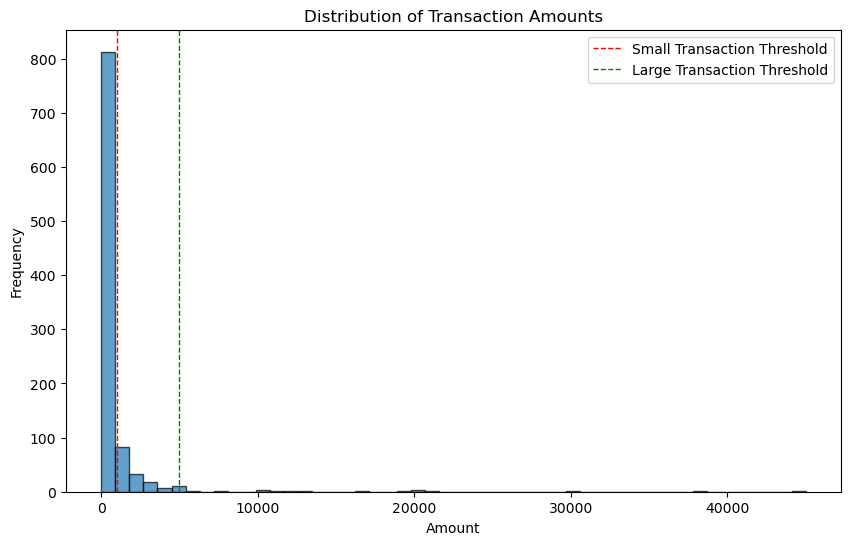

Small transactions (≤1000): 836 (84.87%)
Medium transactions (1000<x≤5000): 127 (12.89%)
Large transactions (>5000): 22 (2.23%)


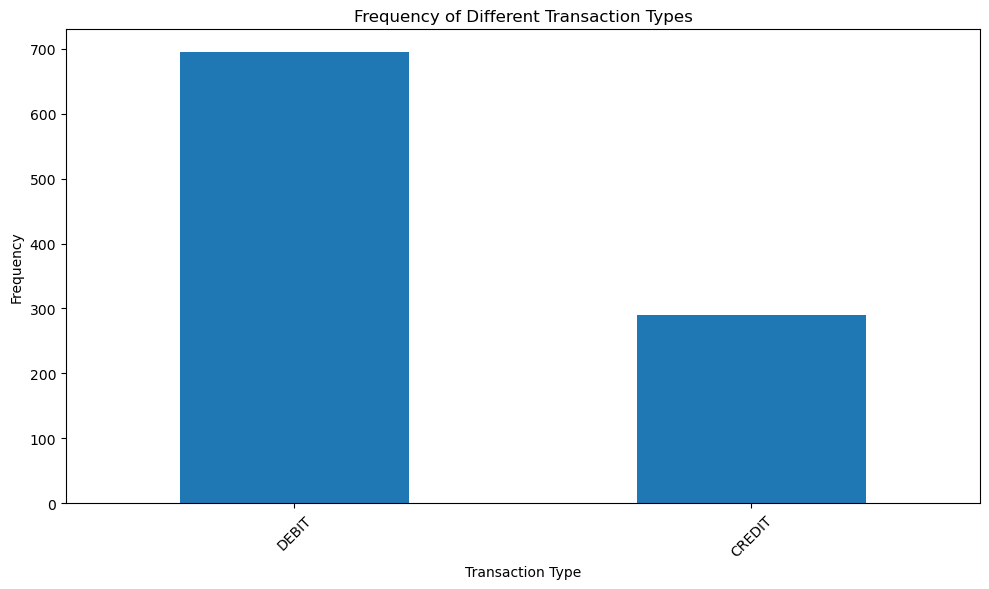


Transaction types:
type
DEBIT     695
CREDIT    290
Name: count, dtype: int64


In [4]:
print("1. Transaction Analysis")
print(f"Total number of transactions: {len(transactions_df)}")

# Distribution of transaction amounts
small_threshold = 1000
large_threshold = 5000

small_transactions = transactions_df[transactions_df['amount'] <= small_threshold]
medium_transactions = transactions_df[(transactions_df['amount'] > small_threshold) & (transactions_df['amount'] <= large_threshold)]
large_transactions = transactions_df[transactions_df['amount'] > large_threshold]

plt.figure(figsize=(10, 6))
plt.hist(transactions_df['amount'], bins=50, edgecolor='k', alpha=0.7)
plt.axvline(small_threshold, color='r', linestyle='dashed', linewidth=1)
plt.axvline(large_threshold, color='g', linestyle='dashed', linewidth=1)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend(['Small Transaction Threshold', 'Large Transaction Threshold'])
plt.show()

print(f"Small transactions (≤{small_threshold}): {len(small_transactions)} ({len(small_transactions)/len(transactions_df)*100:.2f}%)")
print(f"Medium transactions ({small_threshold}<x≤{large_threshold}): {len(medium_transactions)} ({len(medium_transactions)/len(transactions_df)*100:.2f}%)")
print(f"Large transactions (>{large_threshold}): {len(large_transactions)} ({len(large_transactions)/len(transactions_df)*100:.2f}%)")

# Frequency of different transaction types
transaction_types = transactions_df['type'].value_counts()
plt.figure(figsize=(10, 6))
transaction_types.plot(kind='bar')
plt.title('Frequency of Different Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nTransaction types:")
print(transaction_types)

In [5]:
print("\nInsights from Transaction Analysis:")
print(f"1. {len(small_transactions)/len(transactions_df)*100:.2f}% of transactions are small (≤{small_threshold}), "
      f"{len(medium_transactions)/len(transactions_df)*100:.2f}% are medium, and "
      f"{len(large_transactions)/len(transactions_df)*100:.2f}% are large (>{large_threshold}).")
print(f"2. There are {transaction_types['DEBIT']} debit transactions and {transaction_types['CREDIT']} credit transactions.")
print(f"3. The average transaction amount is {transactions_df['amount'].mean():.2f}, with a standard deviation of {transactions_df['amount'].std():.2f}.")



Insights from Transaction Analysis:
1. 84.87% of transactions are small (≤1000), 12.89% are medium, and 2.23% are large (>5000).
2. There are 695 debit transactions and 290 credit transactions.
3. The average transaction amount is 855.49, with a standard deviation of 3007.52.


-----
### Balance Analysis
-----


2. Balance Analysis


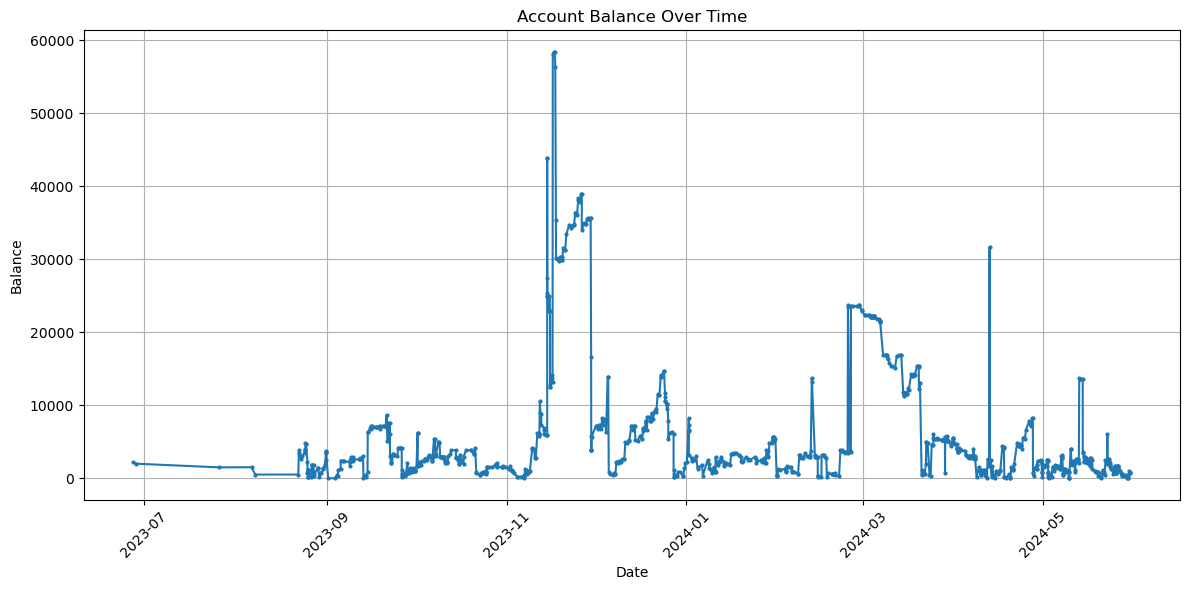

In [7]:
# 2. Balance Analysis
print("\n2. Balance Analysis")
plt.figure(figsize=(12, 6))
plt.plot(transactions_df['transactionTimestamp'], transactions_df['currentBalance'], marker='o', linestyle='-', markersize=2)
plt.title('Account Balance Over Time')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
if 'currentBalance' in transactions_df.columns:
    initial_balance = transactions_df.iloc[0]['currentBalance']
    final_balance = transactions_df.iloc[-1]['currentBalance']
    balance_change = final_balance - initial_balance
    highest_balance = transactions_df['currentBalance'].max()
    lowest_balance = transactions_df['currentBalance'].min()

    print("\nInsights from Balance Analysis:")
    print(f"1. The initial balance was {initial_balance:.2f} and the final balance is {final_balance:.2f}.")
    print(f"2. Over the period, the balance has {'increased' if balance_change > 0 else 'decreased'} by {abs(balance_change):.2f}.")
    print(f"3. The highest balance was {highest_balance:.2f} and the lowest was {lowest_balance:.2f}.")
else:
    print("\nInsights from Balance Analysis:")
    print("Balance information is not available in the dataset.")



Insights from Balance Analysis:
1. The initial balance was 2180.80 and the final balance is 761.41.
2. Over the period, the balance has decreased by 1419.39.
3. The highest balance was 58450.80 and the lowest was 0.80.


----
### Spending Patterns
----


3. Spending Patterns
All transactions by category:
                total_amount  average_amount  frequency
category                                               
UPI                587092.90      744.097465        789
Other              242067.51     1254.235803        193
ATM Withdrawal      13500.00     4500.000000          3

Spending (DEBIT transactions) by category:
                total_amount  average_amount  frequency
category                                               
UPI                 407759.9      592.674273        688
ATM Withdrawal       13500.0     4500.000000          3
Other                  830.0      207.500000          4


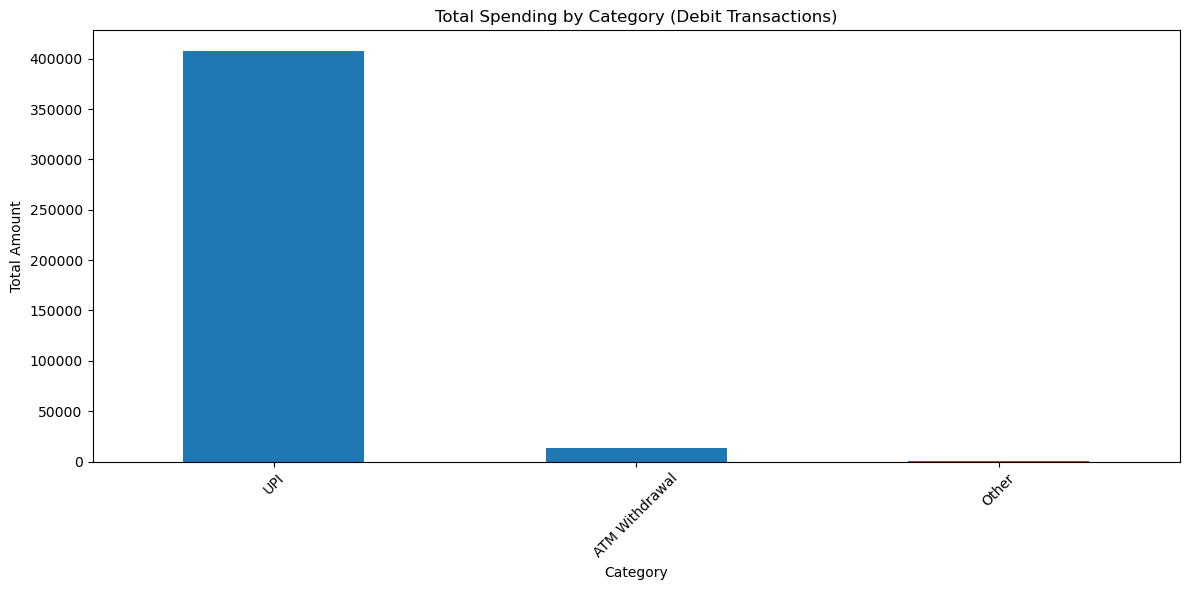

In [10]:
# 3. Spending Patterns
print("\n3. Spending Patterns")
# Analyze all transactions by category
transactions_by_category = transactions_df.groupby('category').agg({
    'amount': ['sum', 'mean', 'count']
})
transactions_by_category.columns = ['total_amount', 'average_amount', 'frequency']
transactions_by_category = transactions_by_category.sort_values('total_amount', ascending=False)

print("All transactions by category:")
print(transactions_by_category)

# Analyze spending (DEBIT transactions) by category
spending_by_category = transactions_df[transactions_df['type'] == 'DEBIT'].groupby('category').agg({
    'amount': ['sum', 'mean', 'count']
})
spending_by_category.columns = ['total_amount', 'average_amount', 'frequency']
spending_by_category = spending_by_category.sort_values('total_amount', ascending=False)

print("\nSpending (DEBIT transactions) by category:")
print(spending_by_category)

# Visualize spending by category
if not spending_by_category.empty:
    plt.figure(figsize=(12, 6))
    spending_by_category['total_amount'].plot(kind='bar')
    plt.title('Total Spending by Category (Debit Transactions)')
    plt.xlabel('Category')
    plt.ylabel('Total Amount')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [11]:
print("\nInsights from Spending Patterns:")
print(f"1. The top spending category is {spending_by_category.index[0]}, with a total spend of {spending_by_category['total_amount'].iloc[0]:.2f}.")
print(f"2. The most frequent spending category is {spending_by_category['frequency'].idxmax()}, with {spending_by_category['frequency'].max()} transactions.")
print(f"3. The category with the highest average transaction amount is {spending_by_category['average_amount'].idxmax()}, "
      f"with an average of {spending_by_category['average_amount'].max():.2f} per transaction.")



Insights from Spending Patterns:
1. The top spending category is UPI, with a total spend of 407759.90.
2. The most frequent spending category is UPI, with 688 transactions.
3. The category with the highest average transaction amount is ATM Withdrawal, with an average of 4500.00 per transaction.


----
### Income Analysis
----


4. Income Analysis
Income sources:
          total_amount  average_amount  frequency
category                                         
Other        241237.51     1276.388942        189
UPI          179333.00     1775.574257        101


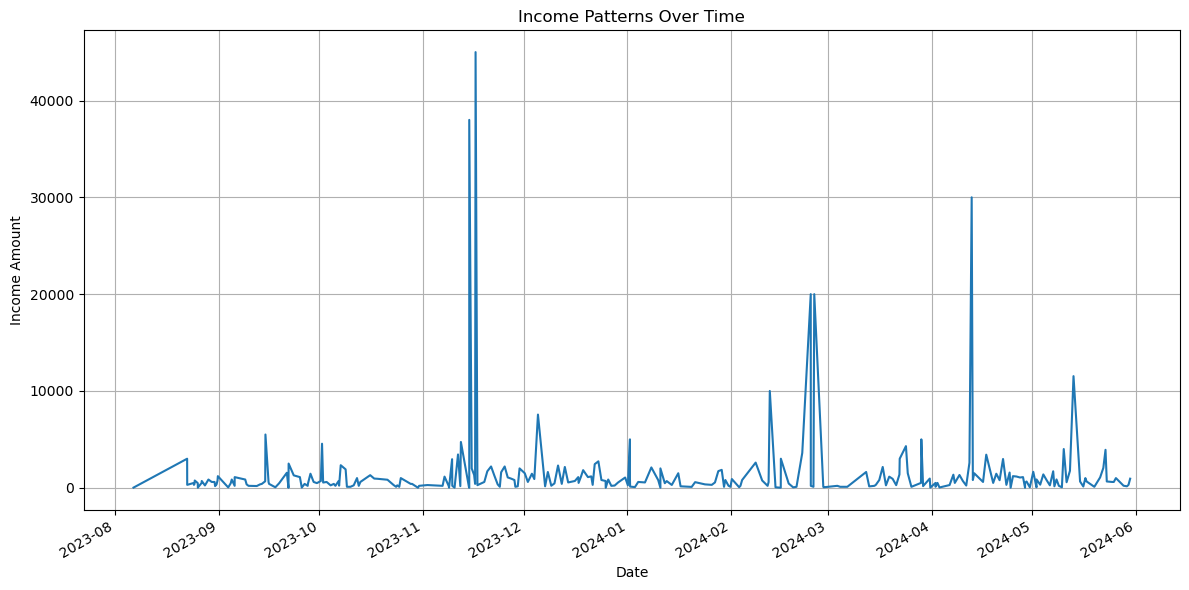

In [13]:
# 4. Income Analysis
print("\n4. Income Analysis")
# Analyze income transactions
income_transactions = transactions_df[transactions_df['type'] == 'CREDIT']
income_sources = income_transactions.groupby('category').agg({
    'amount': ['sum', 'mean', 'count']
})
income_sources.columns = ['total_amount', 'average_amount', 'frequency']
income_sources = income_sources.sort_values('total_amount', ascending=False)

print("Income sources:")
print(income_sources)

# Visualize income patterns
plt.figure(figsize=(12, 6))
income_transactions.set_index('transactionTimestamp')['amount'].plot()
plt.title('Income Patterns Over Time')
plt.xlabel('Date')
plt.ylabel('Income Amount')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
print("\nInsights from Income Analysis:")
print(f"1. The main source of income is from the {income_sources.index[0]} category, totaling {income_sources['total_amount'].iloc[0]:.2f}.")
print(f"2. There are {len(income_sources)} different categories of income sources.")
print(f"3. The average income transaction is {income_transactions['amount'].mean():.2f}, occurring {len(income_transactions)} times over the period.")



Insights from Income Analysis:
1. The main source of income is from the Other category, totaling 241237.51.
2. There are 2 different categories of income sources.
3. The average income transaction is 1450.24, occurring 290 times over the period.


----
### Alert Generation
----

In [16]:
# 5. Alert Generation
print("\n5. Alert Generation")
# Identify unusual transactions
mean_amount = transactions_df['amount'].mean()
std_amount = transactions_df['amount'].std()
unusual_transactions = transactions_df[abs(transactions_df['amount'] - mean_amount) > 3*std_amount]

print("Unusual transactions:")
for _, row in unusual_transactions.iterrows():
    print(f"Date: {row['transactionTimestamp']}, Amount: {row['amount']}, Type: {row['type']}, Category: {row['category']}")

# Generate alerts for low balance or high expenditure periods
max_balance = transactions_df['currentBalance'].max()
low_balance_threshold = 0.1 * max_balance

low_balance_alerts = transactions_df[transactions_df['currentBalance'] < low_balance_threshold]

print("\nLow balance alerts:")
for _, row in low_balance_alerts.iterrows():
    print(f"Date: {row['transactionTimestamp']}, Balance: {row['currentBalance']}")

# Calculate average daily spending
daily_spending = transactions_df[transactions_df['type'] == 'DEBIT'].groupby(transactions_df['transactionTimestamp'].dt.date)['amount'].sum()
avg_daily_spending = daily_spending.mean()
high_spending_threshold = 2 * avg_daily_spending

high_spending_alerts = daily_spending[daily_spending > high_spending_threshold]

print("\nHigh expenditure alerts:")
for date, amount in high_spending_alerts.items():
    print(f"Date: {date}, Total spending: {amount}")


5. Alert Generation
Unusual transactions:
Date: 2023-11-14 18:31:11+05:30, Amount: 37999.0, Type: CREDIT, Category: UPI
Date: 2023-11-14 18:49:41+05:30, Amount: 16500.0, Type: DEBIT, Category: UPI
Date: 2023-11-15 17:48:21+05:30, Amount: 10000.0, Type: DEBIT, Category: UPI
Date: 2023-11-16 15:51:14+05:30, Amount: 45000.0, Type: CREDIT, Category: Other
Date: 2023-11-17 16:34:54+05:30, Amount: 21000.0, Type: DEBIT, Category: UPI
Date: 2023-11-29 16:15:33+05:30, Amount: 19000.0, Type: DEBIT, Category: UPI
Date: 2023-11-29 17:09:47+05:30, Amount: 12700.0, Type: DEBIT, Category: UPI
Date: 2023-12-05 15:50:06+05:30, Amount: 13000.0, Type: DEBIT, Category: UPI
Date: 2024-02-12 13:22:57+05:30, Amount: 10000.0, Type: CREDIT, Category: UPI
Date: 2024-02-13 14:01:51+05:30, Amount: 10000.0, Type: DEBIT, Category: ATM Withdrawal
Date: 2024-02-24 18:55:15+05:30, Amount: 20000.0, Type: CREDIT, Category: UPI
Date: 2024-02-25 11:08:34+05:30, Amount: 20000.0, Type: DEBIT, Category: UPI
Date: 2024-02-25

In [17]:
print("\nInsights from Alert Generation:")
print(f"1. There are {len(unusual_transactions)} unusual transactions that deviate significantly from the average.")
print(f"2. The account balance fell below {low_balance_threshold:.2f} (10% of max balance) {len(low_balance_alerts)} times.")
print(f"3. There were {len(high_spending_alerts)} days with unusually high spending (more than twice the daily average of {avg_daily_spending:.2f}).")



Insights from Alert Generation:
1. There are 18 unusual transactions that deviate significantly from the average.
2. The account balance fell below 5845.08 (10% of max balance) 740 times.
3. There were 31 days with unusually high spending (more than twice the daily average of 1642.37).
